## **Deep Learning - Motion_Deblur**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

In [2]:
tf.random.set_seed(101)
np.random.seed(101)

In [3]:
print(device_lib.list_local_devices())

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU is available.")
else:
    print("No GPU found.")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9444404537609892805
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7389852136674549554
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
GPU is available.


## **Step 1 : Obtaining data**

#### 1.1 Download data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

# Check dimensions
print(f"Train old data has dimensions : {x_train.shape}")
print(f"Test old data has dimensions : {x_test.shape}")

# We shuffle train and extact validation set
idx = np.random.permutation(x_train.shape[0])
x_train = x_train[idx, :, :]

x_val = x_train[55000:, :, :]
x_train = x_train[:55000, :, :]

# Check new dimensions
print()
print(f"Train new data has dimensions : {x_train.shape}")
print(f"Val new data has dimensions : {x_val.shape}")
print(f"Test new data has dimensions : {x_test.shape}") # i did not actually change test data, this print statement is only for "cleanliness" of code

Train old data has dimensions : (60000, 28, 28)
Test old data has dimensions : (10000, 28, 28)

Train new data has dimensions : (55000, 28, 28)
Val new data has dimensions : (5000, 28, 28)
Test new data has dimensions : (10000, 28, 28)


#### 1.2 Data augmentation (Code from the provided notebook)

In [5]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

In [6]:
my_gen = generator(x_train,6)

In [7]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

6


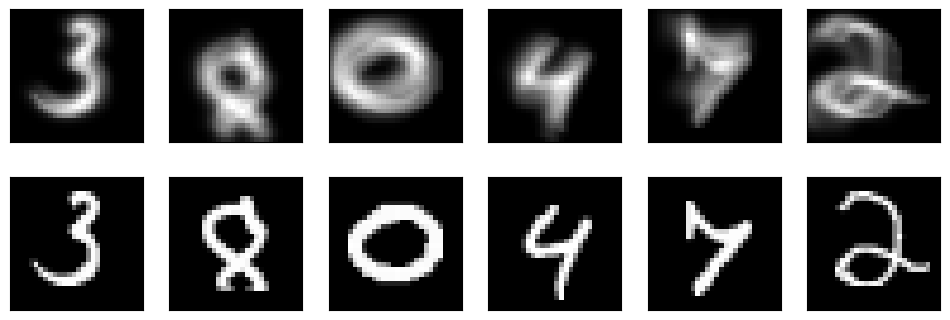

In [8]:
x,y = next(my_gen)
plot(x,y)

## **Step 2 : Model definition**

For the discussion of chosen architecture go at the end of the nootebook.

In [9]:
def build_deblurring_model(input_shape):

    model = Sequential()

    model.add(Conv2D(32, (9, 9), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (9, 9), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(1, (3, 3), activation='linear', padding='same'))

    return model

In [10]:
model_input_shape = (28, 28, 1) #MNIST image dimensions
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [11]:
# Model
deblurring_model = build_deblurring_model(model_input_shape)
deblurring_model.compile(optimizer=optimizer, loss='mean_squared_error')
deblurring_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2624      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        100416    
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 batch_normalization_2 (Bat  (None, 28, 28, 128)       5

## **Step 3 : Model Training**

In [29]:
# Training parameters
batch_size = 16
num_epochs = 14
train_steps = len(x_train) // batch_size
val_steps = len(x_val) // batch_size

# Early stopping function in order to stop training if we start overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=2,
                               restore_best_weights=True,
                               start_from_epoch=5)

In [30]:
train_generator = generator(x_train, batch_size)
val_generator = generator(x_val, batch_size)
test_generator = generator(x_test, 10000)

In [4]:
# Train loop
for epoch in range(num_epochs):
    deblurring_model.fit(train_generator,
                         steps_per_epoch=train_steps,
                         epochs=1,
                         validation_data=val_generator,
                         validation_steps=val_steps,
                         verbose=1,
                         callbacks=[early_stopping])

3437/3437 [==============================] - 576s 168ms/step - loss: 0.0026 - val_loss: 0.0024


## **Step 4 : Model Evaluation**

In [33]:
mse_values = []
epochs = 10

for i in range(epochs):
    test_data = next(test_generator)
    blurred_images, ground_truth = test_data[0], test_data[1]
    predictions = deblurring_model.predict(blurred_images, verbose=0)
    predictions = predictions.squeeze(axis=-1)
    mse = np.mean(tf.keras.losses.mean_squared_error(ground_truth, predictions).numpy())
    mse_values.append(mse)
    print(f"Iteration {i+1}/10, {i+1}th set, MSE value: {mse:.6}")

Iteration 1/10, 1th set, MSE value: 0.0024037
Iteration 2/10, 2th set, MSE value: 0.00243721
Iteration 3/10, 3th set, MSE value: 0.00239025
Iteration 4/10, 4th set, MSE value: 0.00245996
Iteration 5/10, 5th set, MSE value: 0.00243883
Iteration 6/10, 6th set, MSE value: 0.002455
Iteration 7/10, 7th set, MSE value: 0.00236845
Iteration 8/10, 8th set, MSE value: 0.00240418
Iteration 9/10, 9th set, MSE value: 0.00244855
Iteration 10/10, 10th set, MSE value: 0.00245051


In [34]:
# Compute mean and standard deviation of MSE values over the ten rounds
mean_mse = np.mean(mse_values)
std_mse = np.std(mse_values)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE over 10 rounds: {std_mse}")

Mean MSE over 10 rounds: 0.002425665268674493
Standard Deviation of MSE over 10 rounds: 2.9928150979685597e-05


We start from the discussion of the chosen model for training:

- Channel Configuration: The inspiration for the number of channels came from the U-Net architecture. This decision aimed to capture not only pixel relationships but also their spatial locations within the image effectively.

- Batch Normalization: The inclusion of batch normalization after each layer seemed to improve convergence. In particular during experiments with larger batch sizes, the absence of batch normalization adversely affected the network's performance making it very slow and with much more errors with respect to architectures that used it.

- Activation Function Choice: The ReLU function was preferred over Leaky ReLU and Parametric ReLU. I justified this choiced in this way: the size of the network, with 1.3 million parameters, made the dead neurons issue less prominent, and Parametric ReLU introduced a substantial number of parameters, leading to increased training time.

- Kernel Size Selection: The use of larger kernels, such as (9,9), was driven by observations that smaller kernels, like (3,3), struggled to capture structures spanning more than a few pixels. The model exhibited more effective loss reduction with larger kernels.

- Two-Step Model Division: The model is divided into two steps. The first step utilizes large kernels and increased channels to capture intricate details. In the second step, this process is repeated but reducing number of channels.

Moving on to hyperparameters:
- Learning Rate and optimizer: A large learning rate was initially chosen due to its positive impact on convergence in the first epoch. It was later fine-tuned directly by the Adam optimizer, eliminating the need for manual adjustments.

- Batch Size: The batch size was determined empirically through multiple trials, starting from smaller sizes and gradually increasing. The final choice was based on which batch decreased more the loss.

- Loss Function: Mean Squared Error was ultimately chosen for its simplicity and because it directly gave an idea of how the model was going.

- Validation Set: A small part of the train set was used to create the validation set. This was very useful in checking if the model, especially if complex, was overfitting a simple dataset like MNIST.

- Number of Epochs: During empiric testing it was seen that the number of epochs before overfitting were of variable range due to randomness located in the generator function. In order to not being dependent from a particular trial i decided to use early stopping. Setting a high value of num_epochs so that i could deeply train the models for as much epochs as possible: if the right criteria for early stopping were met during training the execution would have been terminated by the model itself.